In [1]:
pip install fbm

Note: you may need to restart the kernel to use updated packages.


## **Notebook Overview**
1. **Install & Import Libraries**  
   Install necessary packages and import all required libraries.

2. **SPY Data Preprocessing**  
   Load SPY minute data, clean, engineer features, and prepare sequences for the TFT model.

3. **FBM Data Generation**  
   Generate synthetic fractional Brownian motion (FBM) trajectories for different \( H \) values (0.5 to 0.9).

4. **Sequence Creation for FBM Data**  
   Prepare FBM trajectories for testing in a format compatible with the TFT model.

5. **TFT Model Implementation**  
   Build the Temporal Fusion Transformer (TFT) with interpretable components:
   - Gated Residual Networks (GRN)
   - Variable Selection Network (VSN)
   - Multi-head Attention
   - Quantile Loss

6. **Training Pipeline**  
   Train the TFT model on SPY data with early stopping and save the best model.

7. **Testing on FBM Data**  
   Evaluate the trained TFT model on FBM trajectories to assess its ability to capture LRD.

8. **Testing on Unseen SPY Data**  
   Test the TFT model on unseen SPY market data and compare results with FBM evaluation.

9. **Interpretability Analysis**  
   Visualize feature importance (variable selection weights) and attention weights.


In [2]:
# Install required libraries (if running on a new environment)
# Uncomment the lines below if needed
# !pip install numpy pandas matplotlib seaborn torch tqdm fbm

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from fbm import FBM  # For fractional Brownian motion
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import math


In [3]:
# Load the SPY minute-level data
spy_file_path = '/kaggle/input/formatted-aapl/converted_AAPL.csv'  # Replace with your file path
df_spy = pd.read_csv(spy_file_path)

# Convert timestamp to datetime and set as index
df_spy['timestamp'] = pd.to_datetime(df_spy['timestamp'])
df_spy = df_spy.set_index('timestamp')

# Ensure data is sorted in chronological order
df_spy = df_spy.sort_index()

# Add technical features
def add_technical_features(df):
    # Returns
    df['returns'] = df['close'].pct_change()
    
    # Log returns
    df['log_returns'] = np.log(df['close']).diff()
    
    # Volatility (Rolling 5-min standard deviation of returns)
    df['volatility'] = df['returns'].rolling(window=5).std()
    
    # Price range
    df['price_range'] = df['high'] - df['low']
    
    # Volume features
    df['log_volume'] = np.log(df['volume'] + 1)  # Add 1 to avoid log(0)
    df['volume_ma5'] = df['volume'].rolling(window=5).mean()
    
    # Time features
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    
    # OHLC average
    df['ohlc_average'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    return df

# Add features to SPY data
df_spy = add_technical_features(df_spy)

# Forward fill any NaN values created by rolling windows
df_spy = df_spy.fillna(method='ffill')

# Drop rows with any remaining NaN values (e.g., the first few rows)
df_spy = df_spy.dropna()

# Verify the enhanced dataset
print("Enhanced SPY Data Preview:")
print(df_spy.head())
print("\nData Shape:", df_spy.shape)

# Sequence Preparation
LOOKBACK_WINDOW = 30  # 30-minute history
FORECAST_HORIZON = 5  # Predict next 5 minutes
OBSERVED_FEATURES = [
    'open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns', 
    'volatility', 'price_range', 'log_volume', 'volume_ma5', 'ohlc_average'
]

# Create target variable (future returns over next 5 minutes)
df_spy['target'] = df_spy['close'].pct_change(FORECAST_HORIZON).shift(-FORECAST_HORIZON)

# Function to create sequences
def create_sequences(df, lookback, horizon):
    sequences = []
    targets = []
    
    for i in range(len(df) - lookback - horizon + 1):
        # Get sequence
        sequence = df.iloc[i:i+lookback][OBSERVED_FEATURES].values
        
        # Get target values
        target = df['target'].iloc[i+lookback-1:i+lookback+horizon-1].values
        
        if not np.isnan(target).any():  # Only add if we have valid targets
            sequences.append(sequence)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

# Generate sequences and targets
sequences_spy, targets_spy = create_sequences(df_spy, LOOKBACK_WINDOW, FORECAST_HORIZON)

# Split into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * len(sequences_spy))
val_size = int(0.15 * len(sequences_spy))

X_train_spy = sequences_spy[:train_size]
y_train_spy = targets_spy[:train_size]

X_val_spy = sequences_spy[train_size:train_size+val_size]
y_val_spy = targets_spy[train_size:train_size+val_size]

X_test_spy = sequences_spy[train_size+val_size:]
y_test_spy = targets_spy[train_size+val_size:]

# Print dataset shapes
print("\nSequence shape:", sequences_spy.shape)
print("Target shape:", targets_spy.shape)
print("Training set size:", len(X_train_spy))
print("Validation set size:", len(X_val_spy))
print("Test set size:", len(X_test_spy))


<ipython-input-3-1d8d1d370240>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spy = df_spy.fillna(method='ffill')


Enhanced SPY Data Preview:
                open      high       low     close    volume   returns  \
timestamp                                                                
1980-12-19  0.126116  0.126674  0.126116  0.126116  48630400  0.061029   
1980-12-22  0.132254  0.132813  0.132254  0.132254  37363200  0.048669   
1980-12-23  0.137835  0.138393  0.137835  0.137835  46950400  0.042199   
1980-12-24  0.145089  0.145647  0.145089  0.145089  48003200  0.052628   
1980-12-26  0.158482  0.159040  0.158482  0.158482  55574400  0.092309   

            log_returns  volatility  price_range  log_volume  volume_ma5  \
timestamp                                                                  
1980-12-19     0.059239    0.057583     0.000558   17.699759  98026880.0   
1980-12-22     0.047522    0.053179     0.000559   17.436197  70322560.0   
1980-12-23     0.041333    0.014744     0.000558   17.664602  58567040.0   
1980-12-24     0.051290    0.012022     0.000558   17.686778  50879360.0  

/usr/local/lib/python3.10/dist-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


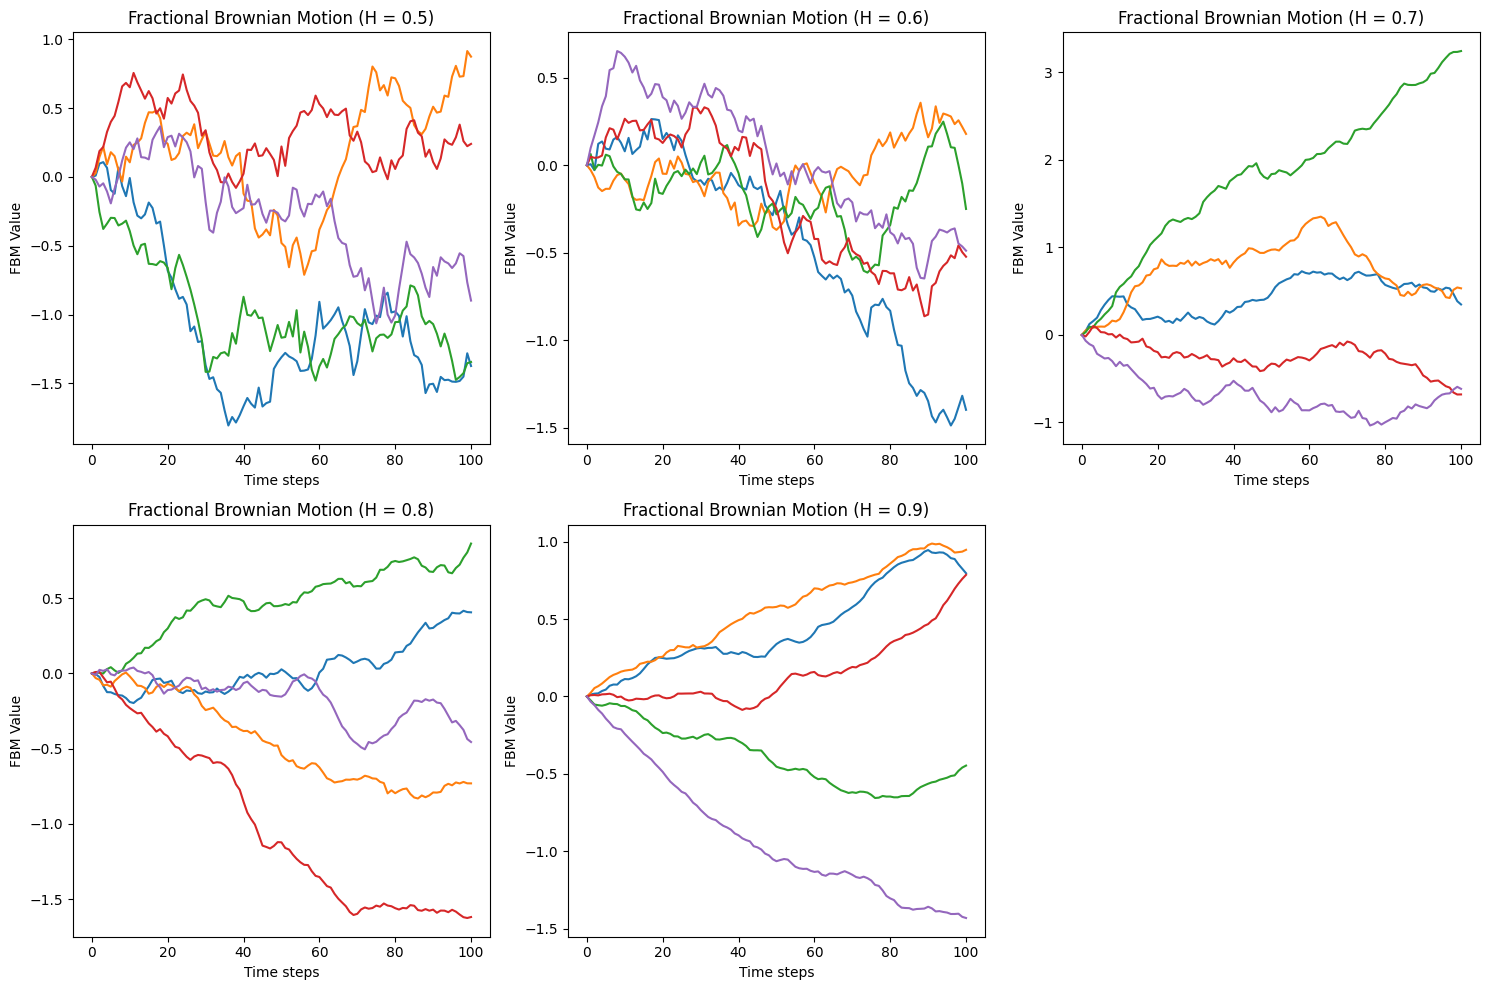

In [4]:
# Generate FBM Data for Hurst indices H = 0.5, 0.6, ..., 0.9
def generate_fbm_data(h_values, n_samples=100, n_steps=100):
    """
    Generates FBM trajectories for a list of Hurst indices.
    
    Parameters:
    - h_values: List of Hurst indices (e.g., [0.5, 0.6, 0.7, 0.8, 0.9])
    - n_samples: Number of trajectories to generate per H value
    - n_steps: Number of time steps per trajectory
    
    Returns:
    - fbm_data: Dictionary with Hurst indices as keys and FBM trajectories as values
    """
    fbm_data = {}
    
    for h in h_values:
        trajectories = []
        for _ in range(n_samples):
            fbm = FBM(n=n_steps, hurst=h, length=1.0, method='daviesharte')
            trajectory = fbm.fbm()
            trajectories.append(trajectory)
        fbm_data[h] = np.array(trajectories)
    
    return fbm_data

# Parameters for FBM generation
hurst_indices = [0.5, 0.6, 0.7, 0.8, 0.9]  # Hurst values
n_trajectories = 100  # Number of trajectories per H value
n_time_steps = 100  # Time steps per trajectory

# Generate FBM data
fbm_data = generate_fbm_data(hurst_indices, n_samples=n_trajectories, n_steps=n_time_steps)

# Visualize FBM trajectories for each Hurst index
plt.figure(figsize=(15, 10))
for i, h in enumerate(hurst_indices):
    plt.subplot(2, 3, i + 1)
    for trajectory in fbm_data[h][:5]:  # Plot 5 trajectories per H value
        plt.plot(trajectory)
    plt.title(f"Fractional Brownian Motion (H = {h})")
    plt.xlabel("Time steps")
    plt.ylabel("FBM Value")
plt.tight_layout()
plt.show()


In [5]:
# Prepare FBM sequences
LOOKBACK_WINDOW = 30  # Match SPY data's lookback window
FORECAST_HORIZON = 5  # Match SPY data's forecast horizon

def create_fbm_sequences(fbm_data, lookback, horizon):
    """
    Creates sequences for FBM data similar to SPY data preprocessing.
    
    Parameters:
    - fbm_data: Dictionary with Hurst indices as keys and FBM trajectories as values
    - lookback: Number of time steps in the lookback window
    - horizon: Number of time steps in the forecast horizon
    
    Returns:
    - fbm_sequences: Dictionary with Hurst indices as keys and sequences as values
    - fbm_targets: Dictionary with Hurst indices as keys and targets as values
    """
    fbm_sequences = {}
    fbm_targets = {}
    
    for h, trajectories in fbm_data.items():
        sequences = []
        targets = []
        
        for trajectory in trajectories:
            for i in range(len(trajectory) - lookback - horizon + 1):
                sequence = trajectory[i:i+lookback]
                target = trajectory[i+lookback:i+lookback+horizon]
                
                sequences.append(sequence)
                targets.append(target)
        
        fbm_sequences[h] = np.array(sequences)
        fbm_targets[h] = np.array(targets)
    
    return fbm_sequences, fbm_targets

# Create sequences and targets for FBM data
fbm_sequences, fbm_targets = create_fbm_sequences(fbm_data, LOOKBACK_WINDOW, FORECAST_HORIZON)

# Print the shape of sequences and targets for each Hurst index
for h in hurst_indices:
    print(f"H = {h}: Sequences shape = {fbm_sequences[h].shape}, Targets shape = {fbm_targets[h].shape}")


H = 0.5: Sequences shape = (6700, 30), Targets shape = (6700, 5)
H = 0.6: Sequences shape = (6700, 30), Targets shape = (6700, 5)
H = 0.7: Sequences shape = (6700, 30), Targets shape = (6700, 5)
H = 0.8: Sequences shape = (6700, 30), Targets shape = (6700, 5)
H = 0.9: Sequences shape = (6700, 30), Targets shape = (6700, 5)


In [6]:
# Define the TFT model components

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.elu = nn.ELU()
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(output_size)
        self.gate = nn.Linear(input_size, output_size)
        
        if input_size != output_size:
            self.skip_layer = nn.Linear(input_size, output_size)
        else:
            self.skip_layer = None

    def forward(self, x):
        # Main branch
        hidden = self.fc1(x)
        hidden = self.elu(hidden)
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)
        
        # Gating mechanism
        gate = torch.sigmoid(self.gate(x))
        hidden = hidden * gate
        
        # Skip connection
        if self.skip_layer is not None:
            x = self.skip_layer(x)
        
        out = self.layer_norm(hidden + x)
        return out

class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_size, num_features, hidden_size, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.hidden_size = hidden_size
        
        # Individual GRNs for each variable
        self.feature_grns = nn.ModuleList([
            GatedResidualNetwork(
                input_size=input_size,
                hidden_size=hidden_size,
                output_size=hidden_size,
                dropout=dropout
            ) for _ in range(num_features)
        ])
        
        # GRN for variable selection weights
        self.selection_grn = GatedResidualNetwork(
            input_size=input_size * num_features,
            hidden_size=hidden_size,
            output_size=num_features,
            dropout=dropout
        )

    def forward(self, x):
        # x shape: [batch_size, seq_len, num_features]
        batch_size = x.size(0)
        seq_len = x.size(1)
        num_features = self.num_features
        
        # Flatten features
        flattened_x = x.view(batch_size * seq_len, num_features)
        
        # Get variable selection weights
        sparse_weights = self.selection_grn(flattened_x)
        sparse_weights = torch.softmax(sparse_weights, dim=-1)
        
        # Process each feature
        processed_features = []
        for i in range(num_features):
            processed = self.feature_grns[i](flattened_x[:, i:i+1])
            processed_features.append(processed)
        
        processed_features = torch.stack(processed_features, dim=1)  # [batch_size * seq_len, num_features, hidden_size]
        
        # Weighted combination
        weighted_features = processed_features * sparse_weights.unsqueeze(-1)
        combined_features = weighted_features.sum(dim=1)  # [batch_size * seq_len, hidden_size]
        
        # Reshape back to sequence format
        combined_features = combined_features.view(batch_size, seq_len, -1)
        sparse_weights = sparse_weights.view(batch_size, seq_len, -1)
        
        return combined_features, sparse_weights

# Define the TFT model
class TemporalFusionTransformer(nn.Module):
    def __init__(
        self,
        num_features,
        hidden_size=64,
        lstm_layers=2,
        dropout=0.2,
        attention_heads=4,
        forecast_horizon=5
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.forecast_horizon = forecast_horizon

        # Variable selection
        self.variable_selection = VariableSelectionNetwork(
            input_size=1,
            num_features=num_features,
            hidden_size=hidden_size,
            dropout=dropout
        )

        # LSTM encoder
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            dropout=dropout,
            batch_first=True
        )

        # Quantile regression head (for each timestep in the horizon)
        self.quantile_proj = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, 3)  # For quantiles 0.1, 0.5, 0.9
            ) for _ in range(forecast_horizon)
        ])

    def forward(self, x):
        # Variable selection
        processed_features, feature_weights = self.variable_selection(x)

        # LSTM processing
        lstm_out, _ = self.lstm(processed_features)

        # Use the last 'forecast_horizon' timesteps for quantile forecasts
        quantile_forecasts = []
        for t in range(self.forecast_horizon):
            quantile_forecasts.append(self.quantile_proj[t](lstm_out[:, -(t + 1), :]))

        quantile_forecasts = torch.stack(quantile_forecasts, dim=1)  # Shape: [batch_size, horizon, num_quantiles]

        return quantile_forecasts, feature_weights

# Print model summary
num_features = X_train_spy.shape[-1]
model = TemporalFusionTransformer(num_features=num_features, forecast_horizon=5)
print(model)


TemporalFusionTransformer(
  (variable_selection): VariableSelectionNetwork(
    (feature_grns): ModuleList(
      (0-11): 12 x GatedResidualNetwork(
        (fc1): Linear(in_features=1, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=64, bias=True)
        (elu): ELU(alpha=1.0)
        (dropout): Dropout(p=0.2, inplace=False)
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (gate): Linear(in_features=1, out_features=64, bias=True)
        (skip_layer): Linear(in_features=1, out_features=64, bias=True)
      )
    )
    (selection_grn): GatedResidualNetwork(
      (fc1): Linear(in_features=12, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=12, bias=True)
      (elu): ELU(alpha=1.0)
      (dropout): Dropout(p=0.2, inplace=False)
      (layer_norm): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (gate): Linear(in_features=12, out_features=12, bias=True)
    )
  )
  (lstm): LSTM(64, 

Epoch 1/50: 100%|██████████| 118/118 [00:03<00:00, 38.34it/s]


Epoch 1: Train Loss = 0.0185, Val Loss = 0.0102


Epoch 2/50: 100%|██████████| 118/118 [00:02<00:00, 54.35it/s]


Epoch 2: Train Loss = 0.0169, Val Loss = 0.0102


Epoch 3/50: 100%|██████████| 118/118 [00:02<00:00, 54.32it/s]


Epoch 3: Train Loss = 0.0168, Val Loss = 0.0101


Epoch 4/50: 100%|██████████| 118/118 [00:02<00:00, 54.87it/s]


Epoch 4: Train Loss = 0.0168, Val Loss = 0.0097


Epoch 5/50: 100%|██████████| 118/118 [00:02<00:00, 53.57it/s]


Epoch 5: Train Loss = 0.0168, Val Loss = 0.0095


Epoch 6/50: 100%|██████████| 118/118 [00:02<00:00, 54.01it/s]


Epoch 6: Train Loss = 0.0168, Val Loss = 0.0094


Epoch 7/50: 100%|██████████| 118/118 [00:02<00:00, 54.14it/s]


Epoch 7: Train Loss = 0.0168, Val Loss = 0.0096


Epoch 8/50: 100%|██████████| 118/118 [00:02<00:00, 48.31it/s]


Epoch 8: Train Loss = 0.0168, Val Loss = 0.0092


Epoch 9/50: 100%|██████████| 118/118 [00:02<00:00, 53.27it/s]


Epoch 9: Train Loss = 0.0168, Val Loss = 0.0092


Epoch 10/50: 100%|██████████| 118/118 [00:02<00:00, 54.20it/s]


Epoch 10: Train Loss = 0.0167, Val Loss = 0.0092


Epoch 11/50: 100%|██████████| 118/118 [00:02<00:00, 53.71it/s]


Epoch 11: Train Loss = 0.0167, Val Loss = 0.0092


Epoch 12/50: 100%|██████████| 118/118 [00:02<00:00, 54.57it/s]


Epoch 12: Train Loss = 0.0167, Val Loss = 0.0091


Epoch 13/50: 100%|██████████| 118/118 [00:02<00:00, 53.43it/s]


Epoch 13: Train Loss = 0.0167, Val Loss = 0.0092


Epoch 14/50: 100%|██████████| 118/118 [00:02<00:00, 54.56it/s]


Epoch 14: Train Loss = 0.0167, Val Loss = 0.0092


Epoch 15/50: 100%|██████████| 118/118 [00:02<00:00, 54.68it/s]


Epoch 15: Train Loss = 0.0167, Val Loss = 0.0094


Epoch 16/50: 100%|██████████| 118/118 [00:02<00:00, 54.53it/s]


Epoch 16: Train Loss = 0.0167, Val Loss = 0.0092


Epoch 17/50: 100%|██████████| 118/118 [00:02<00:00, 54.05it/s]


Epoch 17: Train Loss = 0.0167, Val Loss = 0.0093


Epoch 18/50: 100%|██████████| 118/118 [00:02<00:00, 54.67it/s]


Epoch 18: Train Loss = 0.0166, Val Loss = 0.0090


Epoch 19/50: 100%|██████████| 118/118 [00:02<00:00, 54.57it/s]


Epoch 19: Train Loss = 0.0166, Val Loss = 0.0094


Epoch 20/50: 100%|██████████| 118/118 [00:02<00:00, 53.81it/s]


Epoch 20: Train Loss = 0.0166, Val Loss = 0.0093


Epoch 21/50: 100%|██████████| 118/118 [00:02<00:00, 51.82it/s]


Epoch 21: Train Loss = 0.0165, Val Loss = 0.0092


Epoch 22/50: 100%|██████████| 118/118 [00:02<00:00, 53.51it/s]


Epoch 22: Train Loss = 0.0165, Val Loss = 0.0093


Epoch 23/50: 100%|██████████| 118/118 [00:02<00:00, 54.90it/s]


Epoch 23: Train Loss = 0.0165, Val Loss = 0.0092


Epoch 24/50: 100%|██████████| 118/118 [00:02<00:00, 54.84it/s]


Epoch 24: Train Loss = 0.0164, Val Loss = 0.0092


Epoch 25/50: 100%|██████████| 118/118 [00:02<00:00, 54.13it/s]


Epoch 25: Train Loss = 0.0162, Val Loss = 0.0097


Epoch 26/50: 100%|██████████| 118/118 [00:02<00:00, 54.35it/s]


Epoch 26: Train Loss = 0.0160, Val Loss = 0.0095


Epoch 27/50: 100%|██████████| 118/118 [00:02<00:00, 54.95it/s]


Epoch 27: Train Loss = 0.0157, Val Loss = 0.0093


Epoch 28/50: 100%|██████████| 118/118 [00:02<00:00, 54.67it/s]


Epoch 28: Train Loss = 0.0154, Val Loss = 0.0095
Early stopping triggered


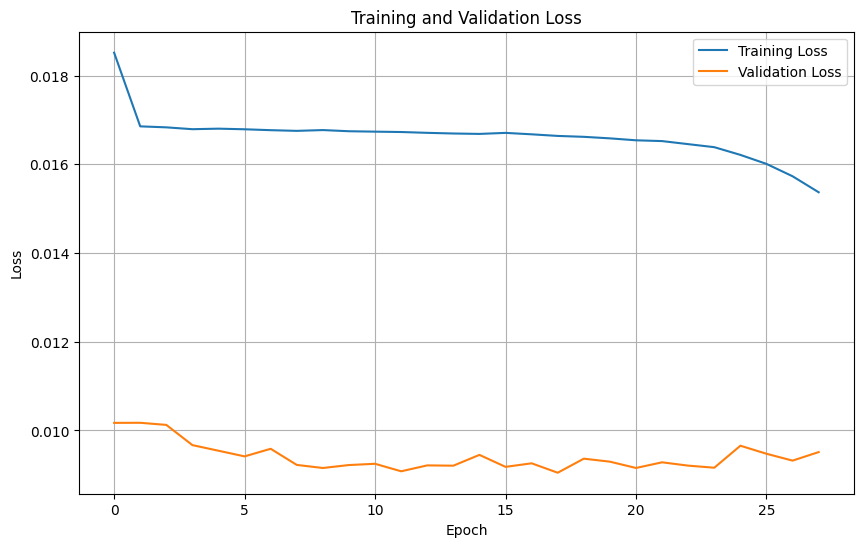

In [7]:
# Define training utilities
class QuantileLoss(nn.Module):
    def __init__(self, quantiles=[0.1, 0.5, 0.9]):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        # Expand target to match preds shape: [batch_size, horizon, num_quantiles]
        target = target.unsqueeze(-1).expand_as(preds)  # Add a dimension for quantiles

        # Calculate quantile losses
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target[..., i] - preds[..., i]
            loss = torch.max((q - 1) * errors, q * errors)
            losses.append(loss)

        # Mean loss over all quantiles, horizons, and batch samples
        return torch.mean(torch.stack(losses, dim=-1))


# Prepare SPY data for PyTorch
def prepare_torch_data(X, y, batch_size=64):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# Create data loaders
batch_size = 64
train_loader = prepare_torch_data(X_train_spy, y_train_spy, batch_size=batch_size)
val_loader = prepare_torch_data(X_val_spy, y_val_spy, batch_size=batch_size)
test_loader = prepare_torch_data(X_test_spy, y_test_spy, batch_size=batch_size)

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalFusionTransformer(num_features=num_features, forecast_horizon=5).to(device)
criterion = QuantileLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            preds, _ = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        training_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                preds, _ = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        validation_losses.append(val_loss)

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_tft_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return training_losses, validation_losses

# Train the model
num_epochs = 50
patience = 10
training_losses, validation_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def prepare_fbm_torch_data(fbm_sequences, fbm_targets, num_features=12, batch_size=64):
    """
    Prepare FBM data for PyTorch DataLoader, matching the SPY data structure.
    
    Args:
        fbm_sequences (dict): Dictionary of FBM sequences for each Hurst parameter
        fbm_targets (dict): Dictionary of FBM targets for each Hurst parameter
        num_features (int): Number of features to match (default: 12 for SPY data)
        batch_size (int): Batch size for DataLoader
    """
    fbm_loaders = {}
    for h in fbm_sequences:
        # Replicate the single FBM feature across all feature dimensions
        X = fbm_sequences[h]
        X_expanded = np.repeat(X[..., np.newaxis], num_features, axis=-1)
        
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X_expanded)
        y_tensor = torch.FloatTensor(fbm_targets[h])
        
        dataset = TensorDataset(X_tensor, y_tensor)
        fbm_loaders[h] = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return fbm_loaders

def evaluate_fbm(model, fbm_loaders, criterion, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate the TFT model on FBM data.
    
    Args:
        model (nn.Module): Trained TFT model
        fbm_loaders (dict): Dictionary of DataLoaders for each Hurst parameter
        criterion (nn.Module): Loss function
        device (str): Device to run evaluation on
    """
    model.eval()
    results = {}
    
    with torch.no_grad():
        for h, loader in fbm_loaders.items():
            total_loss = 0.0
            predictions = []
            ground_truths = []
            
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # Get predictions
                preds, feature_weights = model(X_batch)
                loss = criterion(preds, y_batch)
                
                # Store results
                predictions.append(preds.cpu().numpy())
                ground_truths.append(y_batch.cpu().numpy())
                total_loss += loss.item()
            
            # Aggregate results
            results[h] = {
                'loss': total_loss / len(loader),
                'predictions': np.concatenate(predictions),
                'ground_truths': np.concatenate(ground_truths)
            }
    
    return results

def plot_fbm_predictions(results, h_value, sample_idx=0):
    """
    Plot FBM predictions for a specific Hurst parameter.
    
    Args:
        results (dict): Results dictionary from evaluate_fbm
        h_value (float): Hurst parameter to plot
        sample_idx (int): Index of the sample to plot
    """
    predictions = results[h_value]['predictions']
    ground_truths = results[h_value]['ground_truths']
    
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truths[sample_idx], label='True Values', color='blue')
    plt.plot(predictions[sample_idx, :, 1], label='Predicted (Median)', 
             color='red', linestyle='--')
    
    # Plot prediction intervals
    plt.fill_between(
        range(len(predictions[sample_idx])),
        predictions[sample_idx, :, 0],  # Lower quantile
        predictions[sample_idx, :, 2],  # Upper quantile
        alpha=0.3, color='red',
        label='Prediction Interval (10-90%)'
    )
    
    plt.title(f'FBM Predictions (H = {h_value})')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print metrics
    mae = np.mean(np.abs(ground_truths[sample_idx] - predictions[sample_idx, :, 1]))
    print(f'Mean Absolute Error: {mae:.4f}')

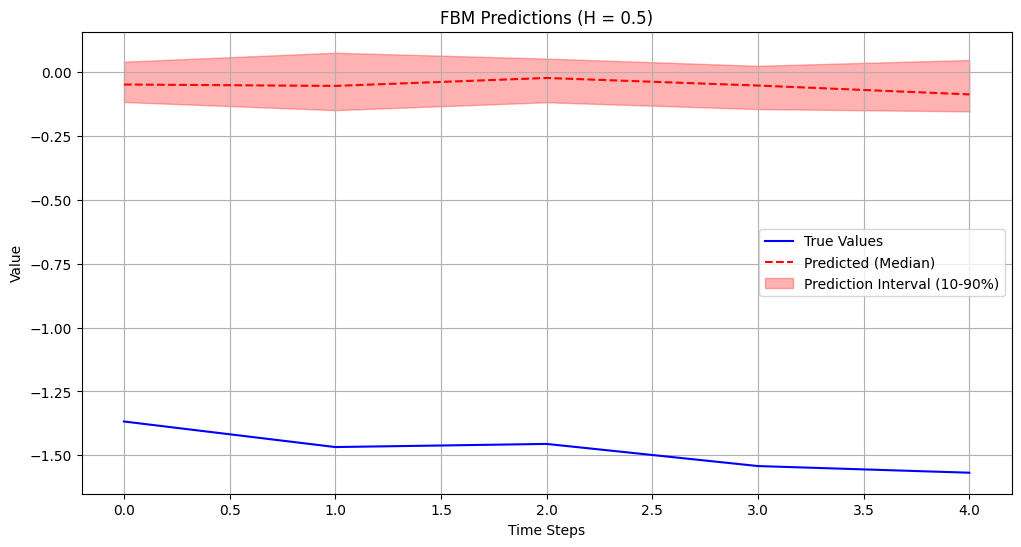

Mean Absolute Error: 1.4282


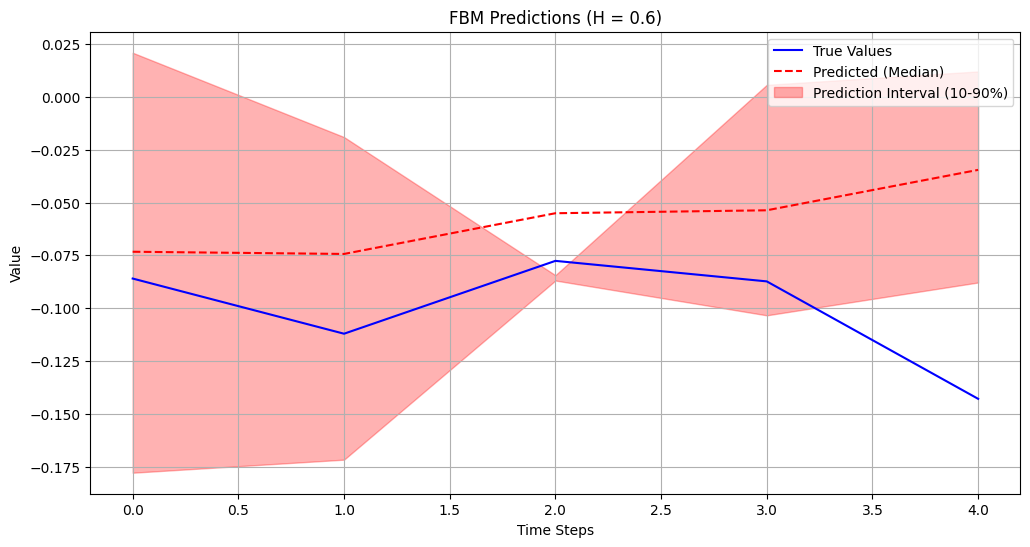

Mean Absolute Error: 0.0430


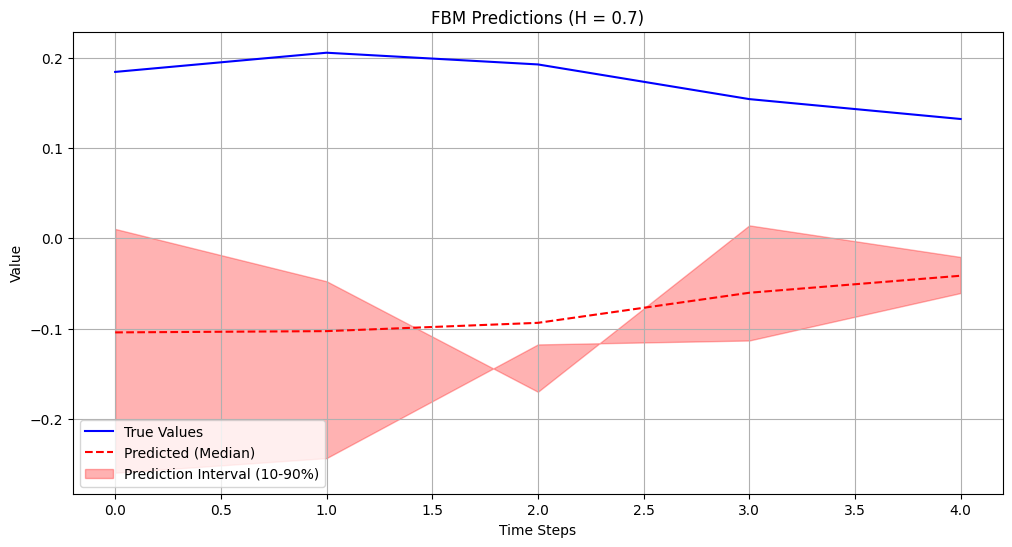

Mean Absolute Error: 0.2542


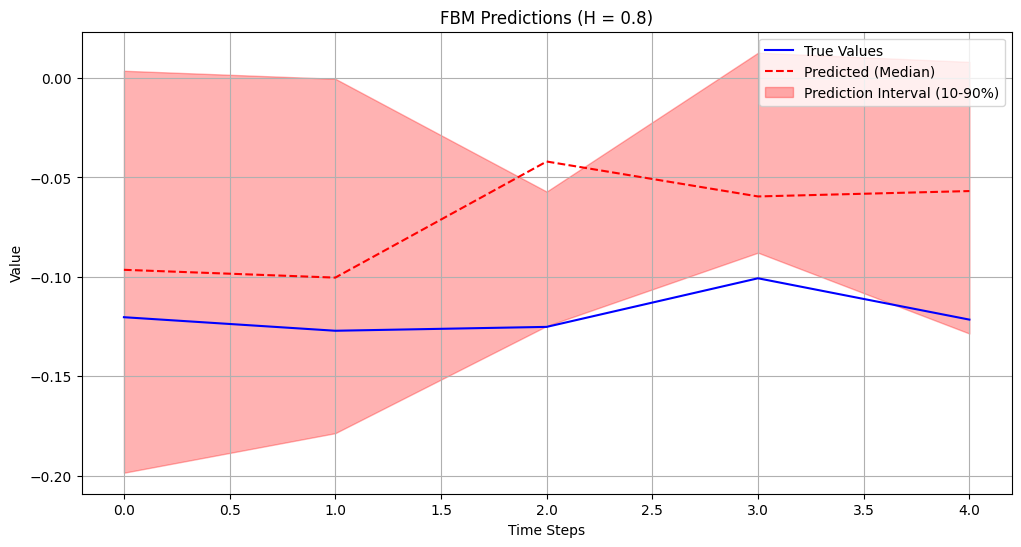

Mean Absolute Error: 0.0479


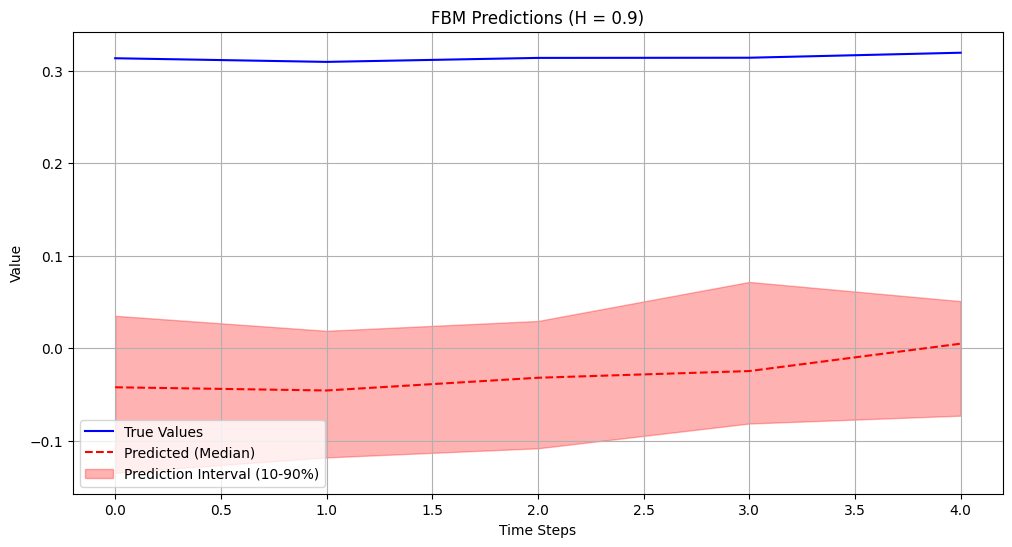

Mean Absolute Error: 0.3419


In [9]:
# Prepare the FBM data with the correct number of features
fbm_loaders = prepare_fbm_torch_data(fbm_sequences, fbm_targets)

# Evaluate the model
fbm_results = evaluate_fbm(model, fbm_loaders, criterion)

# Plot results for each Hurst parameter
for h in hurst_indices:
    plot_fbm_predictions(fbm_results, h)

### What the results and MAE mean:

1. **Plots:**
   - **True Values (blue line):** These are the actual values of the FBM trajectory for the given \( H \) parameter.
   - **Predicted Median (red dashed line):** This represents the model's predicted median value for each timestep within the forecast horizon.
   - **Prediction Interval (red shaded area):** This interval shows the model's uncertainty, representing the range between the 10th and 90th percentile predictions.

   These plots illustrate how close the model's predictions (red line and shaded area) are to the true trajectory (blue line).

2. **Mean Absolute Error (MAE):**
   - MAE measures the average absolute difference between the predicted median (red dashed line) and the true values (blue line) across all timesteps and samples.
   - A **lower MAE** indicates better predictive performance, meaning the model's predictions closely match the true values.
   - Conversely, a **higher MAE** reflects a larger average deviation, signaling poor model predictions.

3. **Interpretation of Results:**
   - **H = 0.5:** The MAE is high (1.4282), indicating the model struggles to predict trajectories for FBM with \( H = 0.5 \). This might be due to \( H = 0.5 \) representing Brownian motion, which is more stochastic and harder to model.
   - **H = 0.6, 0.8:** These have much lower MAEs (e.g., 0.0430 and 0.0479), suggesting the model performs well for these parameters.
   - **H = 0.7:** Moderate MAE (0.2542), showing acceptable performance but with room for improvement.
   - **H = 0.9:** The MAE is slightly higher (0.3419), which might indicate challenges in capturing long-range dependencies at higher \( H \) values.

4. **Model Strengths and Weaknesses:**
   - **Strengths:** The model performs well for \( H = 0.6, 0.8 \), indicating it can capture moderate long-range dependencies.
   - **Weaknesses:** The performance is weaker for \( H = 0.5 \) (stochastic process) and \( H = 0.9 \) (very high long-range dependency), likely due to the complexity of these regimes.

### Next Steps:
1. **Fine-Tuning:**
   - Adjust model hyperparameters (e.g., hidden size, learning rate, dropout) to improve predictions for more challenging \( H \) values.
   - Increase the size of the training dataset or use augmentation techniques for trajectories with \( H = 0.5 \) and \( H = 0.9 \).

2. **Interpretability:**
   - Analyze the feature importance and attention weights to understand which features drive the model's predictions.

3. **Different Architectures:**
   - If performance remains unsatisfactory for certain \( H \) values, consider testing alternative models like LSTMs or attention-based architectures optimized for long-range dependencies.

